# **WORK IN PROGRESS**

- To reduce the database in order to avoid any crash from the Kernel, we will select the 10 most frequent products in the train data base.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import itemfreq
import seaborn as sns
from sklearn.model_selection import train_test_split
%matplotlib inline

import datetime
from datetime import date, timedelta

# **Preparation & Initial Study**

## 0. Load the Data

Let's use a part of the code from [inversion's Kernel](https://www.kaggle.com/inversion/dataframe-with-all-date-store-item-combinations).

In [2]:
dtypes = {'store_nbr': np.dtype('int64'),
          'item_nbr': np.dtype('int64'),
          'unit_sales': np.dtype('float64'),
          'onpromotion': np.dtype('O')}

train = pd.read_csv('../input/train.csv', dtype=dtypes)
test = pd.read_csv('../input/test.csv', dtype=dtypes)
stores = pd.read_csv('../input/stores.csv')
items = pd.read_csv('../input/items.csv')
trans = pd.read_csv('../input/transactions.csv')
#oil = pd.read_csv('../input/oil.csv') #we upload this database later
holidays = pd.read_csv('../input/holidays_events.csv')

In [3]:
date_mask = (train['date'] >= '2017-07-15') & (train['date'] <= '2017-08-15')
pd_train = train[date_mask]

#Print the size
len(pd_train)

3359566

## 1. Feature engineering

### **Oil.csv - Replace missing values**

- We can observe some missing values in the Oil prices database.


In [4]:
#Load the data
oil = pd.read_csv('../input/oil.csv')

#add missing date
min_oil_date = min(pd_train.date)
max_oil_date = max(pd_train.date)

calendar = []

d1 = datetime.datetime.strptime(min_oil_date, '%Y-%m-%d')  # start date date(2008, 8, 15)
d2 = datetime.datetime.strptime(max_oil_date, '%Y-%m-%d')  # end date

delta = d2 - d1         # timedelta

for i in range(delta.days + 1):
    calendar.append(datetime.date.strftime(d1 + timedelta(days=i), '%Y-%m-%d'))

calendar = pd.DataFrame({'date':calendar})

oil = calendar.merge(oil, left_on='date', right_on='date', how='left')

In [5]:
#Check how many NA
print(oil.isnull().sum(), '\n')

#Type
print('Type : ', '\n', oil.dtypes)

#Print the 3 first line
oil.head(5)

date           0
dcoilwtico    10
dtype: int64 

Type :  
 date           object
dcoilwtico    float64
dtype: object


,date,dcoilwtico
0,2017-07-15,NaN
1,2017-07-16,NaN
2,2017-07-17,46.02
3,2017-07-18,46.40
4,2017-07-19,47.10


We will replace the missing value with the following formula : 

$$\frac{(dcoilwtico[t-1] + dcoilwtico[t+1])} {2}$$

In [6]:
#Check index to apply the formula
na_index_oil = oil[oil['dcoilwtico'].isnull() == True].index.values

#Define the index to use to apply the formala
na_index_oil_plus = na_index_oil.copy()
na_index_oil_minus = np.maximum(0, na_index_oil-1)

for i in range(len(na_index_oil)):
    k = 1
    while (na_index_oil[min(i+k,len(na_index_oil)-1)] == na_index_oil[i]+k):
        k += 1
    na_index_oil_plus[i] = min(len(oil)-1, na_index_oil_plus[i] + k )

#Apply the formula
for i in range(len(na_index_oil)):
    if (na_index_oil[i] == 0):
        oil.loc[na_index_oil[i], 'dcoilwtico'] = oil.loc[na_index_oil_plus[i], 'dcoilwtico']
    elif (na_index_oil[i] == len(oil)):
        oil.loc[na_index_oil[i], 'dcoilwtico'] = oil.loc[na_index_oil_minus[i], 'dcoilwtico']
    else:
        oil.loc[na_index_oil[i], 'dcoilwtico'] = (oil.loc[na_index_oil_plus[i], 'dcoilwtico'] + oil.loc[na_index_oil_minus[i], 'dcoilwtico'])/ 2    

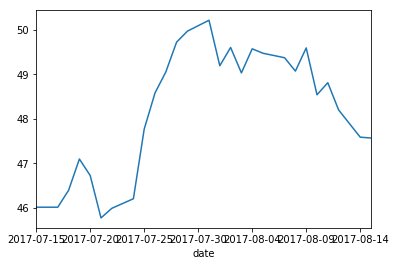

In [7]:
#Plot the oil values
oil_plot = oil['dcoilwtico'].copy()
oil_plot.index = oil['date'].copy()
oil_plot.plot()
plt.show()

## 2. Merge all the database

In [8]:
#Merge train
pd_train = pd_train.drop('id', axis = 1)
pd_train = pd_train.merge(stores, left_on='store_nbr', right_on='store_nbr', how='left')
pd_train = pd_train.merge(items, left_on='item_nbr', right_on='item_nbr', how='left')
pd_train = pd_train.merge(holidays, left_on='date', right_on='date', how='left')
pd_train = pd_train.merge(oil, left_on='date', right_on='date', how='left')
pd_train = pd_train.drop(['description', 'state', 'locale_name', 'class'], axis = 1)

#Merge test - here is the code
test = test.drop('id', axis = 1)
test = test.merge(stores, left_on='store_nbr', right_on='store_nbr', how='left')
test = test.merge(items, left_on='item_nbr', right_on='item_nbr', how='left')
test = test.merge(oil, left_on='date', right_on='date', how='left')
test = test.merge(holidays, left_on='date', right_on='date', how='left')
test = test.drop(['description', 'state', 'locale_name', 'class'], axis = 1)

## 3. Quick look and modification on the data

### **- Newly created Train DataBase**

In [9]:
#Shape
print('Shape : ', pd_train.shape, '\n')

#Type
print('Type : ', '\n', pd_train.dtypes)

#Summary
pd_train.describe()

Shape :  (3359566, 14) 

Type :  
 date            object
store_nbr        int64
item_nbr         int64
unit_sales     float64
onpromotion     object
city            object
type_x          object
cluster          int64
family          object
perishable       int64
type_y          object
locale          object
transferred     object
dcoilwtico     float64
dtype: object


,store_nbr,item_nbr,unit_sales,cluster,perishable,dcoilwtico
count,3.359566e+06,3.359566e+06,3.359566e+06,3.359566e+06,3.359566e+06,3.359566e+06
mean,2.831059e+01,1.171591e+06,8.053185e+00,8.703191e+00,2.580432e-01,4.814635e+01
std,1.630974e+01,5.871905e+05,2.371664e+01,4.566465e+00,4.375579e-01,1.468388e+00
min,1.000000e+00,9.699500e+04,-2.410000e+02,1.000000e+00,0.000000e+00,4.578000e+01
25%,1.300000e+01,6.925310e+05,2.000000e+00,5.000000e+00,0.000000e+00,4.640000e+01
50%,2.900000e+01,1.212452e+06,4.000000e+00,9.000000e+00,0.000000e+00,4.858000e+01
75%,4.400000e+01,1.583407e+06,8.000000e+00,1.300000e+01,1.000000e+00,4.947000e+01
max,5.400000e+01,2.127114e+06,5.901000e+03,1.700000e+01,1.000000e+00,5.021000e+01


In [10]:
#5 random lines
pd_train.sample(10)

,date,store_nbr,item_nbr,unit_sales,onpromotion,city,type_x,cluster,family,perishable,type_y,locale,transferred,dcoilwtico
1200008,2017-07-26,24,315178,4.0,False,Guayaquil,D,1,BEVERAGES,0,NaN,NaN,NaN,48.580
3328008,2017-08-15,40,2053630,1.0,False,Machala,C,3,GROCERY II,0,Holiday,Local,False,47.570
1929763,2017-08-02,17,165704,4.0,False,Quito,C,12,GROCERY I,0,NaN,NaN,NaN,49.600
1970204,2017-08-02,39,1981900,9.0,True,Cuenca,B,6,PERSONAL CARE,0,NaN,NaN,NaN,49.600
279250,2017-07-17,31,1239809,27.0,False,Babahoyo,B,10,DAIRY,1,NaN,NaN,NaN,46.020
2754605,2017-08-10,8,428054,1.0,False,Quito,D,8,GROCERY I,0,Holiday,National,True,48.540
991379,2017-07-24,21,1430040,43.0,False,Santo Domingo,B,6,BEVERAGES,0,Additional,Local,False,46.210
3328615,2017-08-15,41,819194,1.0,False,Machala,D,4,GROCERY I,0,Holiday,Local,False,47.570
762553,2017-07-22,15,2013621,1.0,False,Ibarra,C,15,GROCERY I,0,NaN,NaN,NaN,45.995
1491840,2017-07-29,17,757889,6.0,False,Quito,C,12,CLEANING,0,NaN,NaN,NaN,49.965


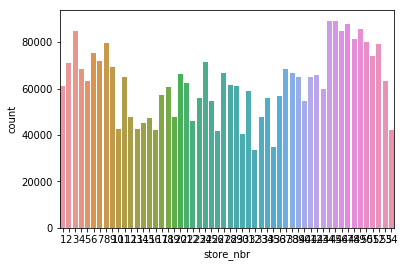

In [11]:
sns.countplot(x='store_nbr', data=pd_train);

### **- Let's extract only the 10 most purchased product**

In [12]:
#######Get the N most purchased products########
def N_most_labels(data, variable , N , all='TRUE'):
    labels_freq_pd = itemfreq(data[variable])
    labels_freq_pd = labels_freq_pd[labels_freq_pd[:, 1].argsort()[::-1]] #[::-1] ==> to sort in descending order
    
    if all == 'FALSE':
        main_labels = labels_freq_pd[:,0][0:N]
    else: 
        main_labels = labels_freq_pd[:,0][:]
        
    labels_raw_np = data[variable].as_matrix() #transform in numpy
    labels_raw_np = labels_raw_np.reshape(labels_raw_np.shape[0],1)

    labels_filtered_index = np.where(labels_raw_np == main_labels)
    
    return labels_freq_pd, labels_filtered_index

label_freq, labels_filtered_index = N_most_labels(data = pd_train, variable = "item_nbr", N = 10, all='FALSE')
print("labels_filtered_index[0].shape = ", labels_filtered_index[0].shape)

pd_train_filtered = pd_train.loc[labels_filtered_index[0],:]
print("pd_train_filtered.shape = ", pd_train_filtered.shape)

labels_filtered_index[0].shape =  (17202,)
pd_train_filtered.shape =  (17202, 14)


In [13]:
label_freq[0:10]

array([[2042947,    1726],
       [ 502331,    1724],
       [ 314384,    1723],
       [ 323013,    1722],
       [ 364606,    1722],
       [ 222879,    1720],
       [2042941,    1719],
       [ 414750,    1716],
       [1162382,    1715],
       [1418845,    1715]])

In [14]:
pd_train_filtered.sample(3)

,date,store_nbr,item_nbr,unit_sales,onpromotion,city,type_x,cluster,family,perishable,type_y,locale,transferred,dcoilwtico
202199,2017-07-16,46,1418845,45.0,False,Quito,A,14,GROCERY I,0,NaN,NaN,NaN,46.02
2114521,2017-08-04,3,2042947,205.0,False,Quito,D,8,BEVERAGES,0,NaN,NaN,NaN,49.57
1379924,2017-07-28,12,364606,27.0,False,Latacunga,C,15,GROCERY I,0,NaN,NaN,NaN,49.72


### **- Replace NA for "holydays" variables**

In [15]:
#Fill in cells if there is no holyday by the value : "no_holyday"
na_index_pd_train = pd_train_filtered[pd_train_filtered['type_y'].isnull() == True].index.values
print("Size of na_index_pd_train : ", len(na_index_pd_train), '\n')

pd_train_filtered.loc[pd_train_filtered['type_y'].isnull(), 'type_y'] = "no_holyday"
pd_train_filtered.loc[pd_train_filtered['locale'].isnull(), 'locale'] = "no_holyday"
pd_train_filtered.loc[pd_train_filtered['transferred'].isnull(), 'transferred'] = "no_holyday"
    
#check is there is NA
pd_train_filtered.isnull().sum()

Size of na_index_pd_train :  13439 



date           0
store_nbr      0
item_nbr       0
unit_sales     0
onpromotion    0
city           0
type_x         0
cluster        0
family         0
perishable     0
type_y         0
locale         0
transferred    0
dcoilwtico     0
dtype: int64

### **- Reformat the date**

We will extract the day, the month and the year from the 'date' variable.

In [16]:
def get_month_year(df):
    df['month'] = df.date.apply(lambda x: x.split('-')[1])
    df['year'] = df.date.apply(lambda x: x.split('-')[0])
    
    return df

get_month_year(pd_train_filtered);

In [17]:
pd_train_filtered['date'] = pd.to_datetime(pd_train_filtered['date'])
pd_train_filtered['day'] = pd_train_filtered['date'].dt.weekday_name
pd_train_filtered = pd_train_filtered.drop('date', axis=1)

In [18]:
pd_train_filtered.sample(10)

,store_nbr,item_nbr,unit_sales,onpromotion,city,type_x,cluster,family,perishable,type_y,locale,transferred,dcoilwtico,month,year,day
2716649,45,364606,66.0,False,Quito,A,11,GROCERY I,0,no_holyday,no_holyday,no_holyday,49.59,08,2017,Wednesday
1365324,4,2042941,213.0,True,Quito,D,9,BEVERAGES,0,no_holyday,no_holyday,no_holyday,49.72,07,2017,Friday
337212,5,1162382,28.0,False,Santo Domingo,D,4,GROCERY I,0,no_holyday,no_holyday,no_holyday,46.40,07,2017,Tuesday
2044799,22,414750,26.0,False,Puyo,C,7,GROCERY I,0,no_holyday,no_holyday,no_holyday,49.03,08,2017,Thursday
639683,5,502331,27.0,False,Santo Domingo,D,4,BREAD/BAKERY,1,no_holyday,no_holyday,no_holyday,45.78,07,2017,Friday
3266615,5,1418845,6.0,False,Santo Domingo,D,4,GROCERY I,0,Holiday,Local,False,47.57,08,2017,Tuesday
1281081,12,323013,4.0,False,Latacunga,C,15,GROCERY I,0,no_holyday,no_holyday,no_holyday,49.05,07,2017,Thursday
1128839,41,1418845,9.0,False,Machala,D,4,GROCERY I,0,Additional,Local,False,47.77,07,2017,Tuesday
2828443,50,314384,65.0,True,Ambato,A,14,GROCERY I,0,Holiday,National,True,48.54,08,2017,Thursday
65267,35,502331,16.0,False,Playas,C,3,BREAD/BAKERY,1,no_holyday,no_holyday,no_holyday,46.02,07,2017,Saturday


## 3. Dummy variables

We will create binary variables.

In [19]:
dummy_variables = ['onpromotion','city','type_x','cluster','store_nbr','item_nbr',
                'family','perishable','type_y', 'locale', 'transferred', 'month', 'day']

for var in dummy_variables:
    dummy = pd.get_dummies(pd_train_filtered[var], prefix = var, drop_first = False)
    pd_train_filtered = pd.concat([pd_train_filtered, dummy], axis = 1)

pd_train_filtered = pd_train_filtered.drop(dummy_variables, axis = 1)
pd_train_filtered = pd_train_filtered.drop(['year'], axis = 1)

In [20]:
print('Shape : ', pd_train_filtered.shape)
pd_train_filtered.sample(10)

Shape :  (17202, 136)


,unit_sales,dcoilwtico,onpromotion_False,onpromotion_True,city_Ambato,city_Babahoyo,city_Cayambe,city_Cuenca,city_Daule,city_El Carmen,...,transferred_no_holyday,month_07,month_08,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
1281081,4.0,49.05,1,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,1,0,0
1365650,31.0,49.72,1,0,0,0,0,0,0,0,...,1,1,0,1,0,0,0,0,0,0
1200062,55.0,48.58,1,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,1
1720103,22.0,50.21,1,0,0,0,0,0,0,0,...,1,1,0,0,1,0,0,0,0,0
2335223,11.0,49.42,1,0,0,0,0,0,0,0,...,1,0,1,0,0,0,1,0,0,0
695562,3.0,45.78,1,0,0,0,0,0,0,0,...,1,1,0,1,0,0,0,0,0,0
965820,7.0,46.21,1,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
3037076,303.0,48.20,1,0,0,0,0,0,0,0,...,1,0,1,0,0,1,0,0,0,0
1312640,8.0,49.05,1,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,1,0,0
1446259,7.0,49.72,1,0,0,0,0,0,0,0,...,1,1,0,1,0,0,0,0,0,0


## 4. Scale variables

We will scale variables so they are normalized with 0 mean and with a standard deviation equal to 1.

In [21]:
scalable_variables = ['unit_sales','dcoilwtico']

for var in scalable_variables:
    mean, std = pd_train[var].mean(), pd_train_filtered[var].std()
    pd_train_filtered.loc[:,var] = (pd_train_filtered[var] - mean) / std

In [22]:
print('Shape : ', pd_train_filtered.shape)
pd_train_filtered.sample(10)

Shape :  (17202, 136)


,unit_sales,dcoilwtico,onpromotion_False,onpromotion_True,city_Ambato,city_Babahoyo,city_Cayambe,city_Cuenca,city_Daule,city_El Carmen,...,transferred_no_holyday,month_07,month_08,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
376241,0.298540,-1.198094,0,1,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,1,0
1324007,0.255783,0.619955,1,0,0,0,0,1,0,0,...,1,1,0,0,0,0,0,1,0,0
930097,0.526577,-1.402196,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1958037,0.241531,0.997286,1,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,1
3270710,0.156017,-0.395408,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1545529,0.270035,1.247696,1,0,0,0,0,0,0,0,...,1,1,0,0,0,1,0,0,0,0
2023040,0.597838,0.606234,1,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,1,0,0
1269568,0.184522,0.619955,1,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,1,0,0
1718910,0.227279,1.415780,1,0,0,0,0,0,0,0,...,1,1,0,0,1,0,0,0,0,0
961178,1.509984,-1.328445,1,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0


## **Split the data into a train and a validation database**

In [23]:
#train database without uni_sales
pd_train_filtered = pd_train_filtered.reset_index(drop=True)  #we reset the index
y_labels = pd_train_filtered['unit_sales']
X_train_filtered = pd_train_filtered.drop(['unit_sales'], axis = 1)

print('Shape X :', X_train_filtered.shape)
print('Shape y :', y_labels.shape)

Shape X : (17202, 135)
Shape y : (17202,)


We split the train database with the function train_test_split (very useful and easy to use function).

In [24]:
num_test = 0.20
X_train, X_validation, y_train, y_validation = train_test_split(X_train_filtered, y_labels, test_size=num_test, random_state=15)
print('X_train shape :', X_train.shape)
print('y_train shape :', y_train.shape)
print('X_validation shape :', X_validation.shape)
print('y_validation shape :', y_validation.shape)

X_train shape : (13761, 135)
y_train shape : (13761,)
X_validation shape : (3441, 135)
y_validation shape : (3441,)


# **Random Forest**

Before trying to build a neural network, we will try to predict the sales with a random forest (for the fun). We already know that because we cannot use all the data in this kaggle kernel, the results might not be good. Nevertheless, it might be interesting to compare different method.

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Choose the type of classifier. 
RFR = RandomForestRegressor()

# Choose some parameter combinations to try
#YOU CAN TRY DIFFERENTS PARAMETERS TO FIND THE BEST MODEL
parameters = {'n_estimators': [5, 10, 100],
              #'criterion': ['mse'],
              #'max_depth': [5, 10, 15], 
              #'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1,5]
             }

# Type of scoring used to compare parameter combinations
#We have to use RandomForestRegressor's own scorer (which is R^2 score)

# Run the grid search
grid_obj = GridSearchCV(RFR, parameters,
                        cv=5, #Determines the cross-validation splitting strategy /to specify the number of folds in a (Stratified)KFold
                        n_jobs=-1, #Number of jobs to run in parallel
                        verbose=1)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
RFR = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
RFR.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   35.3s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [26]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

predictions = RFR.predict(X_validation)
print('R2 score = ',r2_score(y_validation, predictions), '/ 1.0')
print('MSE score = ',mean_squared_error(y_validation, predictions), '/ 0.0')

R2 score =  0.898724818739 / 1.0
MSE score =  0.0926162135026 / 0.0


# **Neural Network with Keras**

## WORK IN PROGRESS